In [7]:
!pip install pydantic-settings -q & source install_spikeinterface.sh

Extracted SpikeInterface version from sorted asset: 0.100.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elephant 1.1.1 requires numpy<2,>=1.19.5, but you have numpy 2.2.6 which is incompatible.


In [ ]:
import spikeinterface as si
import spikeinterface.preprocessing as spre
import spikeinterface.curation as sc
import spikeinterface.widgets as sw
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import npc_session

from main import *

In [10]:
session_id = get_single_session_id()
class Params:
    pass
params = Params()
params.filter_type='highpass'
params.compute_pc_features=True
params.n_cpus=-1

print(session_id)

# raw data
ecephys_folder = data_folder / session_id
ecephys_compressed_folder = get_ecephys_folder(session_id, 'compressed')
ecephys_clipped_folder = get_ecephys_folder(session_id, 'clipped')
raw_compressed_folder = ecephys_compressed_folder

# sorted data
sorted_folder = get_sorted_folder(session_id)
postprocessed_folder = sorted_folder / "postprocessed"
curated_folder = sorted_folder / "curated"
pre_curated_folder = sorted_folder / "sorting_precurated"
spikesorted_folder = sorted_folder / "spikesorted"

is_sorting_analyzer = bool(next(spikesorted_folder.glob("*/*.zarr"), None))


# loop through experiments and segments to get the longest one
lengths = []
experiment_inds = {re.search(r'experiment(\d+)', p.name)[1] for p in raw_compressed_folder.iterdir()}
segment_inds = []

for exp_ind in experiment_inds:
    # any probe will do:
    rec_path = sorted(p for p in raw_compressed_folder.iterdir() if p.name.endswith('-AP.zarr') and f'experiment{exp_ind}' in p.name)[0]
    rec = zarr.open(rec_path)
    for k, v in rec.items():
        if not k.startswith('traces_seg'):
            continue
        traces_seg = int(k.split('traces_seg')[-1])
        lengths.append(
            {
                'experiment': exp_ind,
                'traces_seg': traces_seg,
                'recording': traces_seg + 1, # spikeinterface refers to recordings as 1-indexed
                'len': len(v),
            }
        )

longest = sorted(lengths, key=lambda x: x['len'])[-1]

print(f'Selected experiment{longest["experiment"]} recording{longest["recording"]} (approx {longest["len"]/30_000/3600 :.1f} hr)')

# stream name: 
streams =  sorted(
    p
    for p in postprocessed_folder.iterdir() 
    if p.is_dir() and "post" not in p.name
    and f'experiment{longest["experiment"]}' in p.name   
    and f'recording{longest["recording"]}' in p.name 
)

for stream in sorted(streams, key=lambda p: p.name.split('#')[-1]):
    stream_name = stream.name.removesuffix('.zarr')

    # save location
    phy_folder = results_folder / f"{sorted_folder.name}_phy" / stream_name
    phy_folder.mkdir(exist_ok=True, parents=True)
    print(f'Processing {phy_folder}')

    if is_sorting_analyzer:
        we = si.load(postprocessed_folder / stream.name)
    else:
        we = si.load_waveforms(postprocessed_folder / stream.name, with_recording=False)
    break

ecephys_742903_2024-10-22_10-58-35
Selected experiment1 recording1 (approx 2.1 hr)
Processing /root/capsule/results/ecephys_742903_2024-10-22_10-58-35_sorted_2024-11-19_17-26-01_phy/experiment1_Record Node 108#Neuropix-PXI-100.ProbeA-AP_recording1


In [11]:
steps = [ 'remove_contaminated', 'template_similarity', 'maximum_distance_um', 'minimum_spikes']
#['min_spikes', 'remove_contaminated', 'unit_positions', 'correlogram', 'template_similarity']
potential_merges = sc.get_potential_auto_merge(we, steps=steps, maximum_distance_um=40, minimum_spikes=200)

KeyboardInterrupt: 

In [57]:
(173, 413) in potential_merges, len(potential_merges)

(True, 1666)

In [22]:
we.folder.name

'experiment1_Record Node 108#Neuropix-PXI-100.ProbeA-AP_recording1'

In [ ]:
units = (173, 413)
probe = npc_session.ProbeRecord(we.folder.name)
filename


'probeA_173-413'

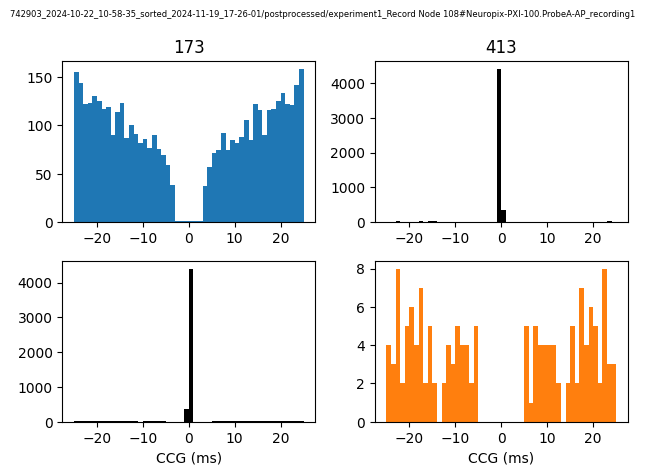

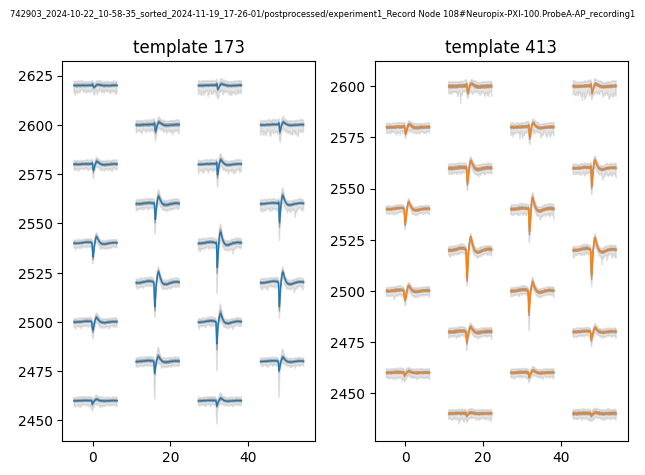

In [26]:
colors=["C0", "C1"]
results_folder = Path('/root/capsule/results/plots')
results_folder.mkdir(exist_ok=True, parents=True)
# potential_merges = [(173, 413)]

for units in potential_merges:
    label = f'probe{probe}_{units[0]}-{units[1]}'
    title = we.folder.as_posix().removeprefix('/root/capsule/data/ecephys_')
    colors_dict = dict(zip(units, colors))
    
    sw.plot_amplitudes(
        we, 
        unit_ids=units, 
        unit_colors=colors_dict, 
        max_spikes_per_unit=None,
        plot_legend=False,
    )
    plt.gcf().suptitle(title, fontsize=6)
    plt.gca().legend(loc='lower center', ncol=2)
    plt.savefig(results_folder / f"{label}_amplitudes.png")
    plt.tight_layout()
    plt.close()

    sw.plot_crosscorrelograms(
        we, 
        unit_ids=units, 
        unit_colors=colors_dict,
    )
    plt.gcf().suptitle(title, fontsize=6)
    plt.tight_layout()
    plt.savefig(results_folder / f"{label}_ccg.png")

    w = sw.plot_unit_templates(we, unit_ids=units, unit_colors=colors_dict, plot_legend=True, lw_templates=1)
    plt.gcf().suptitle(title, fontsize=6)
    plt.tight_layout()
    plt.savefig(results_folder / f"{label}_templates.png")

plt.show()


KeyboardInterrupt: 

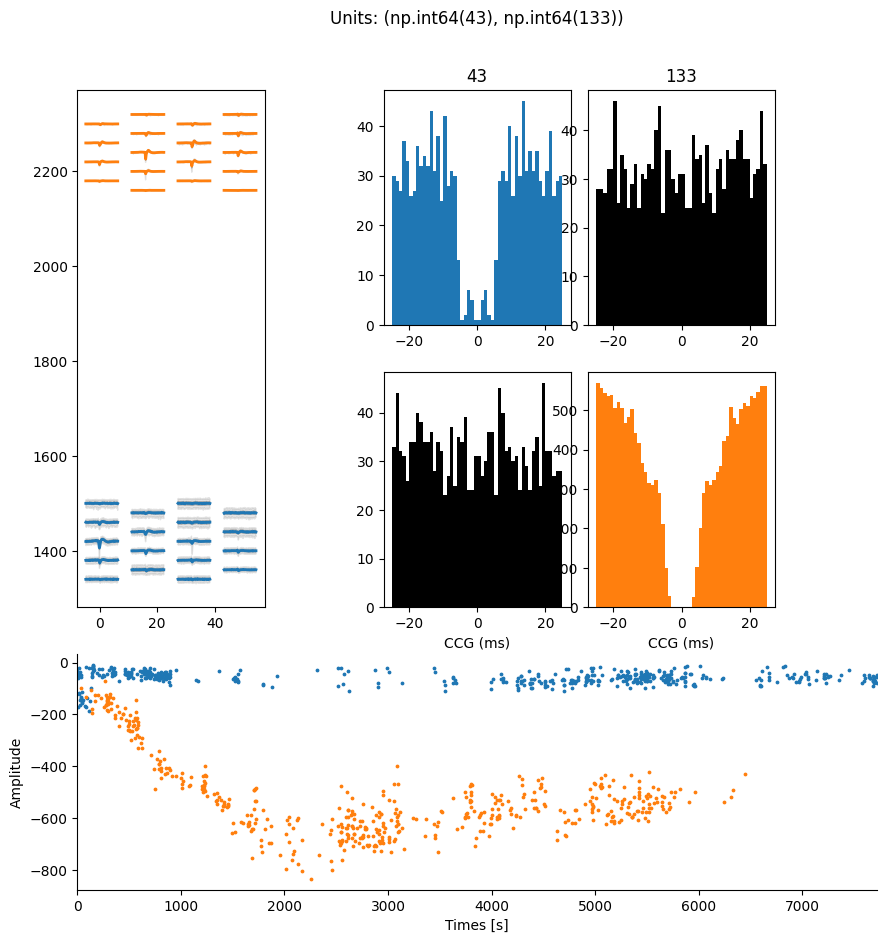

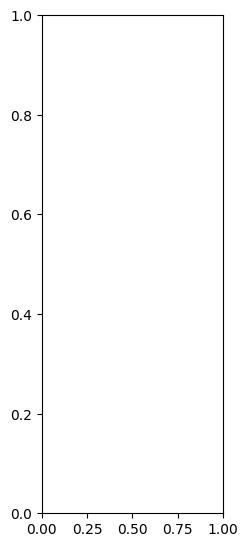

In [19]:
colors=["C0", "C1"]
# templates - ccgs
# -- amplitudes --
figures_dict = dict()
for units_in_merge in potential_merges:
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(3, 8)

    unit0, unit1 = units_in_merge
    # plot templates
    colors_dict = {unit0: colors[0],
                    unit1: colors[1]}
    ax_templates = fig.add_subplot(gs[:2, :2])
    w = sw.plot_unit_templates(we, unit_ids=[unit0], unit_colors=colors_dict,
                                axes=[ax_templates], plot_legend=False)
    w = sw.plot_unit_templates(we, unit_ids=[unit1], unit_colors=colors_dict,
                                axes=[ax_templates], plot_legend=False)
    ax_templates.set_title("")

    ax11 = fig.add_subplot(gs[0, 3:5])
    ax12 = fig.add_subplot(gs[0, 5:7])
    ax21 = fig.add_subplot(gs[1, 3:5])
    ax22 = fig.add_subplot(gs[1, 5:7])
    axs_ccg = np.array([ax11, ax12, ax21, ax22]).reshape((2,2))

    w = sw.plot_crosscorrelograms(we, unit_ids=[unit0, unit1], unit_colors=colors_dict,
                                    axes=axs_ccg)

    ax_amps = fig.add_subplot(gs[2, :])
    w = sw.plot_amplitudes(we, unit_ids=[unit0], unit_colors=colors_dict, max_spikes_per_unit=500,
                            axes=[ax_amps], plot_legend=False)
    w = sw.plot_amplitudes(we, unit_ids=[unit1], unit_colors=colors_dict, max_spikes_per_unit=500,
                            axes=[ax_amps], plot_legend=False)
    fig.suptitle(f"Units: {units_in_merge}")
    figures_dict[f"{units_in_merge}"] = fig


In [20]:
figures_dict

{'(np.int64(43), np.int64(133))': <Figure size 1000x1000 with 6 Axes>}